<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузим-нужные-библиотеки" data-toc-modified-id="Загрузим-нужные-библиотеки-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузим нужные библиотеки</a></span></li><li><span><a href="#Изучение-датасета" data-toc-modified-id="Изучение-датасета-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Изучение датасета</a></span></li><li><span><a href="#Формирование-итогового-набора-признаков-после-изучения-матрицы-фи-корреляции" data-toc-modified-id="Формирование-итогового-набора-признаков-после-изучения-матрицы-фи-корреляции-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Формирование итогового набора признаков после изучения матрицы фи-корреляции</a></span><ul class="toc-item"><li><span><a href="#Заполнение-пропусков-через-Imputer" data-toc-modified-id="Заполнение-пропусков-через-Imputer-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Заполнение пропусков через Imputer</a></span></li></ul></li><li><span><a href="#Формула-метрики" data-toc-modified-id="Формула-метрики-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Формула метрики</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Оценка-точности" data-toc-modified-id="Оценка-точности-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Оценка точности</a></span></li></ul></div>

    Постановщик задачи: Почта России
    Автор решения: Саханенко Дмитрий

# Разработка модели предсказания потери почтовых отправлений

Весь процесс доставки — от приема в отделении до вручения получателю — состоит из большого числа операций. Отправление запаковывают, перевозят на склад и транспортируют между сортировочными пунктами. Если доставка едет из-за границы, то дополнительно появляются операции на зарубежной и российской таможне.

Ускорить и удешевить доставку помогают крупные логистические хабы. Там мелкие грузы сортируются и отправляются в соседние регионы или собираются в новые контейнеры для отправки в другие макрорегионы. Таким образом, почтовые отправления путешествуют по сети сортировочных центров, как кровь по капиллярам, и в конце концов добираются в любые точки нашей страны.

Несмотря на высокий уровень системы безопасности, по-прежнему остается риск пропаж или порчи отправлений: перемещений и операций с посылками очень много, кроме того, в процессе может сыграть человеческий фактор.

Точное предсказание пропаж и их локализация позволит повысить надежность системы — гарантировать доставку отправлений в срок и снизить расходы на транспортировку. Предлагаем участникам чемпионата решить эту задачу — разработать модель предсказания потери почтовых отправлений.

* Подробное описание задачи и данные будут опубликованы в момент старта чемпионата 25 октября в 11:00 (МСК).

## Загрузим нужные библиотеки

In [1]:
# импортируем библиотеки 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import os
import math
import time
import itertools 
import urllib.request
from pathlib import Path

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from catboost import CatBoostClassifier, Pool
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc

from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler

import phik
from phik.report import plot_correlation_matrix
from phik import report

import warnings
warnings.filterwarnings('ignore')
import pickle

from sklearn.utils import shuffle

from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification

#from imblearn.over_sampling import BorderlineSMOTE
#from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
#from sklearn.linear_model import SGDClassifier
#from sklearn.svm import SVC
#from sklearn import tree
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.ensemble import RandomForestClassifier

In [122]:
# зададим глобальные константы для всего проекта

RANDOM_STATE=20221120 #константа

TEST_SIZE=0.3 #размер тестовой выборки

FRACTION_FOR_DOWNSAMPLING=1 #размер выборки для DOWNSAMPLING (доля "0" по 'label' от датасета для обучающей выборки)

In [3]:
# загрузим обучающий датасет
df_train_loaded = pd.read_csv("E:/Чемпионат ИИ 2022/Всероссийский чемпионат окт.-ноя. 2022/Почта России/data/train_dataset_train.csv")


In [4]:
# загрузим тестовый датасет
df_test_loaded = pd.read_csv("E:/Чемпионат ИИ 2022/Всероссийский чемпионат окт.-ноя. 2022/Почта России/data/test_dataset_test.csv")


In [5]:
# загрузим датасет с требуемым форматом выгрузки решения
df_sample_solution_loaded = pd.read_csv("E:/Чемпионат ИИ 2022/Всероссийский чемпионат окт.-ноя. 2022/Почта России/data/sample_solution.csv")


In [6]:
df_train = df_train_loaded.copy()
df_test = df_test_loaded.copy()
df_sample_solution = df_sample_solution_loaded.copy()

In [7]:
# создадим класс DataScience для заполнения пропусков, подсчета пустых и нулевых значений

class DataScience:

    def path_to_files(self, path, link):
        Path('datasets').mkdir(parents=True, exist_ok=True)
        def get_file(file_name, url):
            if not os.path.exists(file_name):
                print(file_name, 'файл не найден, будет загружен из сети')
                _ = urllib.request.urlretrieve(url, file_name)
        urls = {
            'datasets': (path, link)
        }
        [get_file(*urls[k]) for k in urls]
        data = pd.read_csv(urls['datasets'][0])
        return data

    def corr_diagram(self, x):
        plt.figure(figsize=(12, 10), dpi=80)
        sns.heatmap(x.corr(), xticklabels=x.corr().columns, yticklabels=x.corr().columns, cmap='RdYlGn', center=0,
                    annot=True)
        plt.title('Диаграмма корреляции', fontsize=22)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    def clean_dataset(self, df):
        assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
        df.dropna(inplace=True)
        indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)

        return df[indices_to_keep].astype(np.float64)

    def missing_zero_values_table(self, df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
            columns={0: 'Zero Values', 1: 'Missing Values', 2: '% of Total Values'})
        mz_table['Total Zero and Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero and Missing Values'] = 100 * mz_table['Total Zero and Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[mz_table.iloc[:, 1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        print("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"
           "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.") 
        print("Number of rows that have at least one NaN", df.isnull().any(axis=1).sum(), " or ",  f"{df.isnull().any(axis=1).sum() / len(df):.1%}")        
        return mz_table

    def space_zero_values_table(self, df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        space_val = (df == ' ').sum(axis=0)
        space_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, space_val, space_val_percent], axis=1)
        mz_table = mz_table.rename(
            columns={0: 'Zero Values', 1: 'Space Values', 2: '% of Total Values'})
        mz_table['Total Zero and Space Values'] = mz_table['Zero Values'] + mz_table['Space Values']
        mz_table['% Total Zero and Space Values'] = 100 * mz_table['Total Zero and Space Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[mz_table.iloc[:, 1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        print("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"
           "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.") 
        print("Number of rows that have at least one NaN", df.isnull().any(axis=1).sum(), " or ",  f"{df.isnull().any(axis=1).sum() / len(df):.1%}")        
        return mz_table    
    
    def fill_with_mode(self, column, column1, column2):
        df[column] = df.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))  

In [8]:
# присвоим переменной ds созданный класс DataScience
ds = DataScience()

## Изучение датасета

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             object 
 6   class                          float64
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  mailrank                       float64
 13  directctg                      float64
 14  transport_pay                  float64
 15  postmark                       float64
 16  name_mfi                       object 
 17  weight_mfi                     float64
 18  pr

In [10]:
df_train.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629.0,Участок,7503.0,N,0.0,Y,N,87.0,...,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0
1,9907176,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,107.0,...,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0
2,3304275,1018_-1,620962.0,Цех,7503.0,N,0.0,Y,N,50.0,...,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0
3,9020937,1019_-1,344964.0,Цех,7503.0,N,0.0,Y,N,416.0,...,55.0,2060928.0,653280.0,2714208.0,19562334.0,0,0,0,0,0
4,3082311,1020_-1,629819.0,Участок,7503.0,N,0.0,Y,N,795.0,...,16.0,316919.0,27911.0,344830.0,4719186.0,0,0,0,0,0


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 28 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             object 
 6   class                          float64
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  mailrank                       float64
 13  directctg                      float64
 14  transport_pay                  float64
 15  postmark                       float64
 16  name_mfi                       object 
 17  weight_mfi                     float64
 18  pr

In [12]:
df_test.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address
0,7815282,8_13,102976.0,ММПО,7503.0,N,0.0,N,N,85.0,...,489.0,972.0,68766046.0,91123247.0,159889293.0,164927295.0,0,0,0,0
1,8443555,8_2,238753.0,ГОПС,7503.0,N,4.0,Y,N,21.0,...,186.0,2.0,2895.0,1545.0,4440.0,20623.0,0,1,1,0
2,6352559,1020_-1,618254.0,ГОПС,7503.0,N,4.0,Y,N,388.0,...,500.0,3.0,2751.0,993.0,3744.0,37817.0,0,0,0,0
3,4921420,1016_-1,102968.0,ТИ,7503.0,N,0.0,N,N,1203.0,...,0.0,69.0,9379609.0,2267333.0,11646942.0,11759329.0,0,1,0,0
4,1420440,1018_-1,102971.0,Цех,7506.0,N,0.0,N,N,956.0,...,1267.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,1,0,0


In [13]:
df_sample_solution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   id      int64
 1   label   int64
dtypes: int64(2)
memory usage: 61.0 MB


In [14]:
df_sample_solution.head()

,id,label
0,7815282,0
1,8443555,0
2,6352559,0
3,4921420,0
4,1420440,0


In [15]:
# проверим, в точности ли id в df_sample_solution соотвуетствуют df_test
df_test_for_id_examination = df_test.copy()
df_test_for_id_examination['id_from_solution'] = df_sample_solution['id']

# cравниваем строки и записываем результат в новый столбец
df_test_for_id_examination['id_id'] = df_test_for_id_examination['id'] == df_test_for_id_examination['id_from_solution']

# запишем в different_text все строки со значением false
different_text = df_test_for_id_examination[df_test_for_id_examination['id_id'] == False]
 
# выведем разные строки на экран: если таких строк не будет, то соответствие полное
different_text.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,id_from_solution,id_id


In [16]:
# Посмотрим статистику датасета по пропускам
ds.space_zero_values_table(df_train)

Your selected dataframe has 29 columns and 6000000 Rows.
There are 1 columns that have missing values.
Number of rows that have at least one NaN 0  or  0.0%


,Zero Values,Space Values,% of Total Values,Total Zero and Space Values,% Total Zero and Space Values,Data Type
index_oper,1004,154,0.0,1158,0.0,object


In [17]:
# заменим пробелы и нули в обучающей выборке на значение "999999"
df_train.loc[(df_train['index_oper'] == '0'), 'index_oper'] = '999999'
df_train.loc[(df_train['index_oper'] == ' '), 'index_oper'] = '999999'

# заменим пробелы и нули в тестовой выборке на значение "999999"
df_test.loc[(df_test['index_oper'] == '0'), 'index_oper'] = '999999'
df_test.loc[(df_test['index_oper'] == ' '), 'index_oper'] = '999999'

In [18]:
ds.space_zero_values_table(df_train)

Your selected dataframe has 29 columns and 6000000 Rows.
There are 0 columns that have missing values.
Number of rows that have at least one NaN 0  or  0.0%


,Zero Values,Space Values,% of Total Values,Total Zero and Space Values,% Total Zero and Space Values,Data Type


In [19]:
'''ds.space_zero_values_table(df_test)'''

'ds.space_zero_values_table(df_test)'

In [20]:
# приведем к нужным типам столбцы df_train для снижения потребления памяти
df_train['id'] = df_train['id'].astype('object')
df_train['priority'] = df_train['priority'].astype('int32')
df_train['index_oper'] = df_train['index_oper'].astype('float64')
df_train['class'] = df_train['class'].astype('int8')
df_train['weight'] = df_train['weight'].astype('int32')
df_train['mailtype'] = df_train['mailtype'].astype('int8') 
df_train['mailctg'] = df_train['mailctg'].astype('object')
df_train['mailrank'] = df_train['mailrank'].astype('int8') # вообще можно удалить этот столбец, там одни нули
df_train['directctg'] = df_train['directctg'].astype('int8')
df_train['postmark'] = df_train['postmark'].astype('int32')
df_train['dist_qty_oper_login_1'] = df_train['dist_qty_oper_login_1'].astype('int32')
df_train['is_wrong_sndr_name'] = df_train['is_wrong_sndr_name'].astype('int8')
df_train['is_wrong_rcpn_name'] = df_train['is_wrong_rcpn_name'].astype('int8')
df_train['is_wrong_phone_number'] = df_train['is_wrong_phone_number'].astype('int8')
df_train['is_wrong_address'] = df_train['is_wrong_address'].astype('int8')
df_train['label'] = df_train['label'].astype('int8')

#удалим столбец с нулями
#df_train = df_train.drop(['mailrank'], axis=1)

In [21]:
# приведем к нужным типам столбцы df_test для снижения потребления памяти
df_test['id'] = df_test['id'].astype('object')
df_test['priority'] = df_test['priority'].astype('int32')
df_test['index_oper'] = df_test['index_oper'].astype('float64')
df_test['class'] = df_test['class'].astype('int8')
df_test['weight'] = df_test['weight'].astype('int32')
df_test['mailtype'] = df_test['mailtype'].astype('int8') # вообще можно удалить этот столбец, там одни нули
df_test['mailctg'] = df_test['mailctg'].astype('object')
df_test['mailrank'] = df_test['mailrank'].astype('int8')
df_test['directctg'] = df_test['directctg'].astype('int8')
df_test['postmark'] = df_test['postmark'].astype('int32')
df_test['dist_qty_oper_login_1'] = df_test['dist_qty_oper_login_1'].astype('int32')
df_test['is_wrong_sndr_name'] = df_test['is_wrong_sndr_name'].astype('int8')
df_test['is_wrong_rcpn_name'] = df_test['is_wrong_rcpn_name'].astype('int8')
df_test['is_wrong_phone_number'] = df_test['is_wrong_phone_number'].astype('int8')
df_test['is_wrong_address'] = df_test['is_wrong_address'].astype('int8')

#удалим столбец с нулями
#df_test = df_test.drop(['mailrank'], axis=1) 

In [22]:
# проверим на дубликаты
print("Дубликатов выявлено: df_train:", df_train.duplicated().sum())
print("Дубликатов выявлено: df_test:", df_test.duplicated().sum())
print("Дубликатов выявлено: df_sample_solution", df_sample_solution.duplicated().sum())
print("Дубликатов выявлено: df_train['id']", df_train['id'].duplicated().sum())

Дубликатов выявлено: df_train: 0
Дубликатов выявлено: df_test: 0
Дубликатов выявлено: df_sample_solution 0
Дубликатов выявлено: df_train['id'] 0


In [23]:
# приконкатенируем к отдельным категориальным признакам обычную строку (иначе выпадает модель в ошибку)
df_train['index_oper'] = df_train['index_oper'].astype(str) + '_index_oper'
df_test['index_oper'] = df_test['index_oper'].astype(str) + '_index_oper'

df_train['mailctg'] = df_train['mailctg'].astype(str) + '_mailctg'
df_test['mailctg'] = df_test['mailctg'].astype(str) + '_mailctg'

In [24]:
# создадим списки признаков по типам:
# 'int' признаки
num_columns = df_train.select_dtypes(include='int', exclude=None).columns
df_train[num_columns] = df_train[num_columns].astype('float64')

# 'float64' признаки
num_columns_float = df_train.select_dtypes(include='float64', exclude=None).columns
df_train[num_columns_float] = df_train[num_columns_float].astype('int')

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 29 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   id                             object
 1   oper_type + oper_attr          object
 2   index_oper                     object
 3   type                           object
 4   priority                       int32 
 5   is_privatecategory             object
 6   class                          int8  
 7   is_in_yandex                   object
 8   is_return                      object
 9   weight                         int32 
 10  mailtype                       int8  
 11  mailctg                        object
 12  mailrank                       int8  
 13  directctg                      int8  
 14  transport_pay                  int32 
 15  postmark                       int32 
 16  name_mfi                       object
 17  weight_mfi                     int32 
 18  price_mfi             

In [25]:
num_columns = df_test.select_dtypes(include='int', exclude=None).columns
df_test[num_columns] = df_test[num_columns].astype('float64')

num_columns_float = df_test.select_dtypes(include='float64', exclude=None).columns
df_test[num_columns_float] = df_test[num_columns_float].astype('int')

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 28 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   id                             object
 1   oper_type + oper_attr          object
 2   index_oper                     object
 3   type                           object
 4   priority                       int32 
 5   is_privatecategory             object
 6   class                          int8  
 7   is_in_yandex                   object
 8   is_return                      object
 9   weight                         int32 
 10  mailtype                       int8  
 11  mailctg                        object
 12  mailrank                       int8  
 13  directctg                      int8  
 14  transport_pay                  int32 
 15  postmark                       int32 
 16  name_mfi                       object
 17  weight_mfi                     int32 
 18  price_mfi             

In [26]:
# посмотрим на дисбаланс предсказываемого класса
df_train["label"].value_counts()

0    5829020
1     170980
Name: label, dtype: int64

<AxesSubplot:xlabel='class', ylabel='count'>

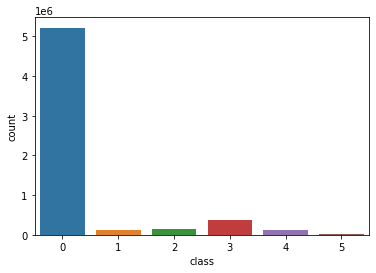

In [27]:
# построим график распределения по признаку "class"
sns.countplot(x = "class" , data  = df_train) 

In [28]:
# очень долго строится
#sns.countplot(x = "weight" , data  = df_train) 

In [29]:
# Посмотрим статистику датасета по пропускам
ds.missing_zero_values_table(df_train)

Your selected dataframe has 29 columns and 6000000 Rows.
There are 0 columns that have missing values.
Number of rows that have at least one NaN 0  or  0.0%


,Zero Values,Missing Values,% of Total Values,Total Zero and Missing Values,% Total Zero and Missing Values,Data Type


In [30]:
# Посмотрим статистику датасета по пропускам
ds.missing_zero_values_table(df_test)

Your selected dataframe has 28 columns and 4000000 Rows.
There are 0 columns that have missing values.
Number of rows that have at least one NaN 0  or  0.0%


,Zero Values,Missing Values,% of Total Values,Total Zero and Missing Values,% Total Zero and Missing Values,Data Type


In [31]:
'''plt.rcParams['figure.figsize']=(20,20)
corr = df_train.iloc[:100000].round(1).corr()
corr = corr.corr()
g = sns.heatmap(corr, square = True, annot=True)'''

"plt.rcParams['figure.figsize']=(20,20)\ncorr = df_train.iloc[:100000].round(1).corr()\ncorr = corr.corr()\ng = sns.heatmap(corr, square = True, annot=True)"

interval columns not set, guessing: ['priority', 'class', 'weight', 'mailtype', 'mailrank', 'directctg', 'transport_pay', 'postmark', 'weight_mfi', 'price_mfi', 'dist_qty_oper_login_1', 'total_qty_oper_login_1', 'total_qty_oper_login_0', 'total_qty_over_index_and_type', 'total_qty_over_index', 'is_wrong_sndr_name', 'is_wrong_rcpn_name', 'is_wrong_phone_number', 'is_wrong_address', 'label']


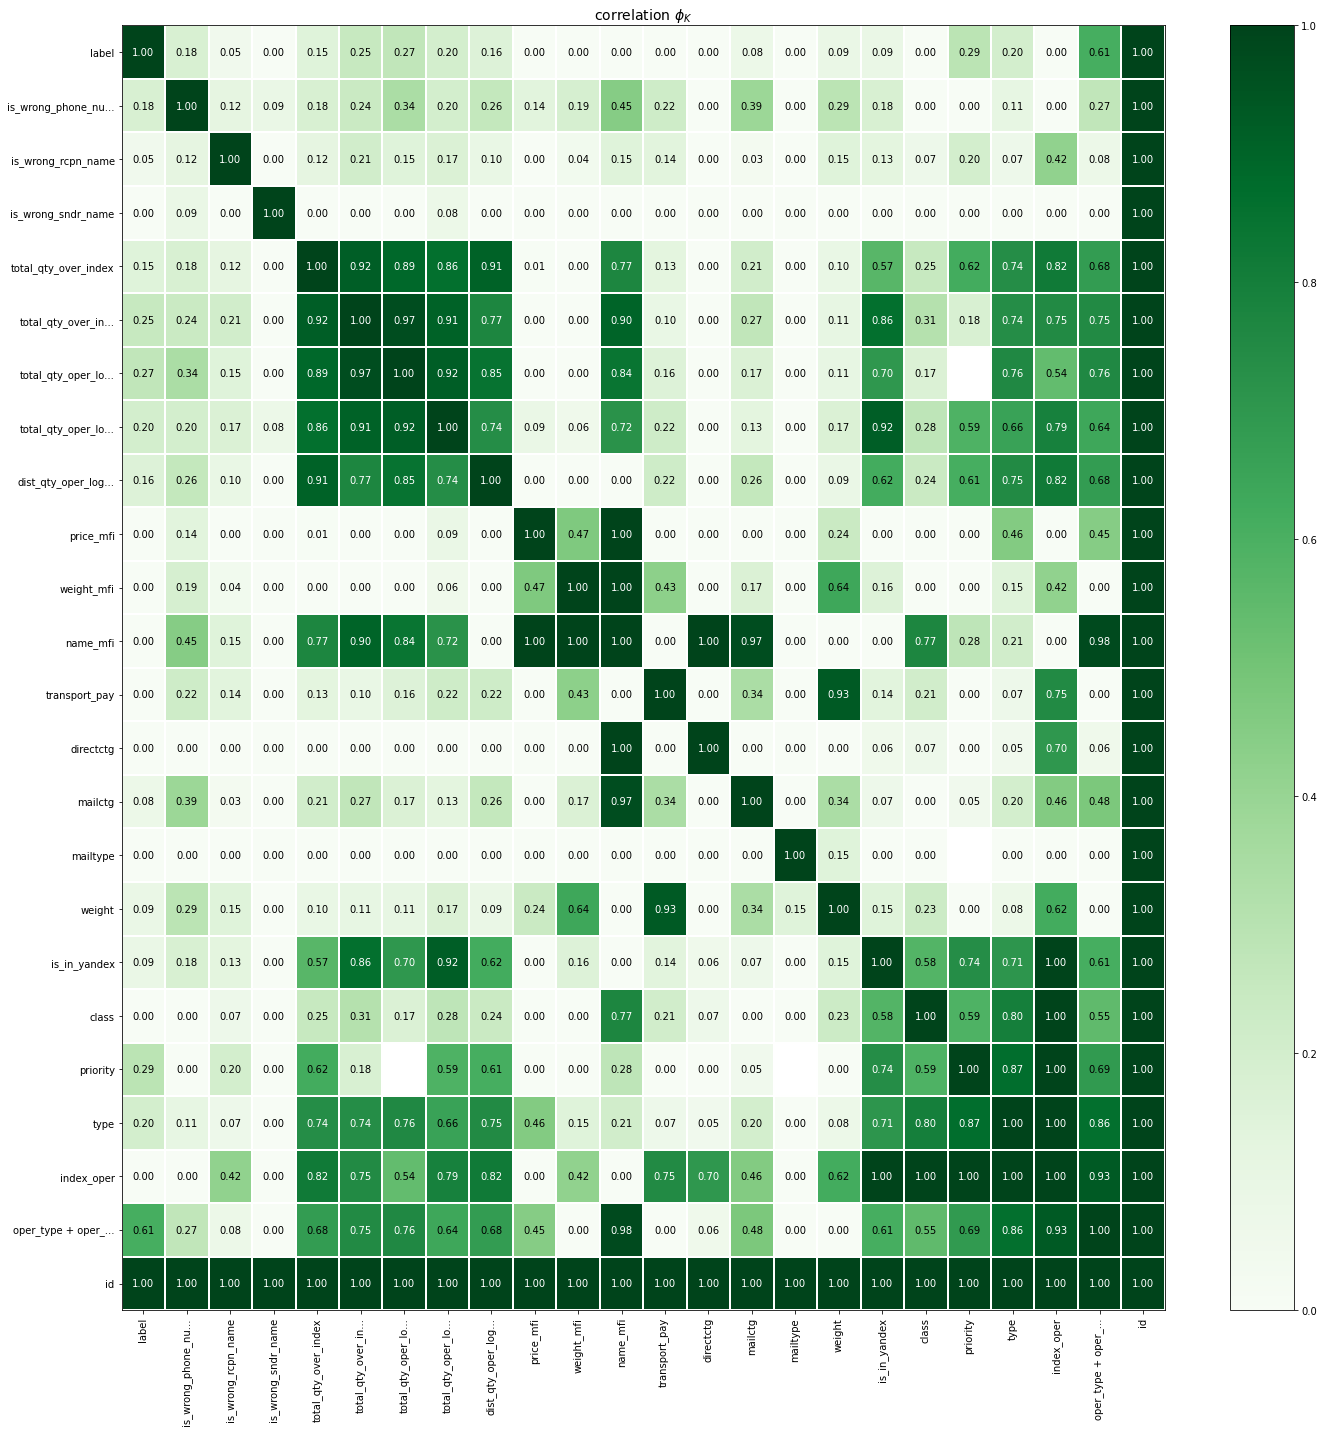

In [32]:
# Построим матрицу корреляции через фи-корреляцию (phik), c помощью 
# которой можно изучать корреляцию признаков 
phik_overview = df_train.iloc[:1000].phik_matrix()
phik_overview = phik_overview.round(2)
# визуализируем полученную матрицу фи-корреляции
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        #fontsize_factor=1.5, 
                        figsize=(20, 20))
plt.tight_layout()

In [33]:
# посмотрим, какие признаки модель CatBoostClassifier оценивает как наиболее важные
features_catboost_importance = df_train.drop(['label'], axis = 1).head(1000000)
target_catboost_importance = df_train['label'].head(1000000)

cat_features_categories = list(features_catboost_importance.select_dtypes('object').columns)

catboost = CatBoostClassifier(random_seed=RANDOM_STATE, silent=True, task_type = "GPU").fit(features_catboost_importance, target_catboost_importance, cat_features=cat_features_categories)
features_importance = catboost.get_feature_importance()
pd.DataFrame(features_importance, index=features_catboost_importance.dtypes.index, columns=['Важность признаков для CatBoostClassifier'])\
    .sort_values(by='Важность признаков для CatBoostClassifier', ascending = False).style.bar()

,Важность признаков для CatBoostClassifier
oper_type + oper_attr,32.096375
total_qty_oper_login_1,11.204370
mailctg,9.044658
total_qty_oper_login_0,7.861624
dist_qty_oper_login_1,5.981940
total_qty_over_index_and_type,5.360359
weight,4.052931
total_qty_over_index,3.611682
is_wrong_phone_number,3.226976
name_mfi,3.034149


In [34]:
# создадим предварительный список с признаками, на которых будет обучаться модель 
list_with_importance_features_train = ['oper_type + oper_attr',
                                'total_qty_oper_login_1',
                                'dist_qty_oper_login_1',
                                'mailctg',
                                'total_qty_oper_login_0',
                                'total_qty_over_index_and_type',
                                'name_mfi',
                                'type',
                                'transport_pay',
                                'weight',
                                'index_oper',
                                'total_qty_over_index',
                                'is_wrong_phone_number',
                                'price_mfi',
                                'is_wrong_rcpn_name',
                                'weight_mfi',
                                'is_in_yandex',
                                       'label']

# посмотрим на количества разных значений по признакам
for i in list_with_importance_features_train:
    print(i)
    print(df_train[i].value_counts(dropna = False))
    print('--------------------------------------------')
    print('--------------------------------------------')
    print('--------------------------------------------')

oper_type + oper_attr
1020_-1    693154
1022_-1    656597
1019_-1    413710
8_0        402877
1_-1       359402
            ...  
2_2             1
12_6            1
2_11            1
2_10            1
1009_-1         1
Name: oper_type + oper_attr, Length: 109, dtype: int64
--------------------------------------------
--------------------------------------------
--------------------------------------------
total_qty_oper_login_1
48856658    795886
64270133    334082
67541214    329741
68766046    272750
76138189    159450
             ...  
38514            1
106624           1
5791             1
44447            1
9588             1
Name: total_qty_oper_login_1, Length: 18377, dtype: int64
--------------------------------------------
--------------------------------------------
--------------------------------------------
dist_qty_oper_login_1
914     795886
1089    334082
184     329741
972     272750
153     239368
         ...  
75           3
135          1
222          1
89      

In [35]:
#list_with_ignore_features_for_catboost = ['mailrank', 
#                                          'postmark', 
#                                          'is_wrong_sndr_name',
#                                          'is_return',
#                                          'id',
#                                          'mailtype',
#                                          'is_privatecategory',
#                                          'class',
#                                          'priority',
#                                          'directctg',
#                                          'is_wrong_address',
#                                          'transport_pay']

interval columns not set, guessing: ['priority', 'class', 'weight', 'mailtype', 'mailrank', 'directctg', 'transport_pay', 'postmark', 'weight_mfi', 'price_mfi', 'dist_qty_oper_login_1', 'total_qty_oper_login_1', 'total_qty_oper_login_0', 'total_qty_over_index_and_type', 'total_qty_over_index', 'is_wrong_sndr_name', 'is_wrong_rcpn_name', 'is_wrong_phone_number', 'is_wrong_address', 'label']


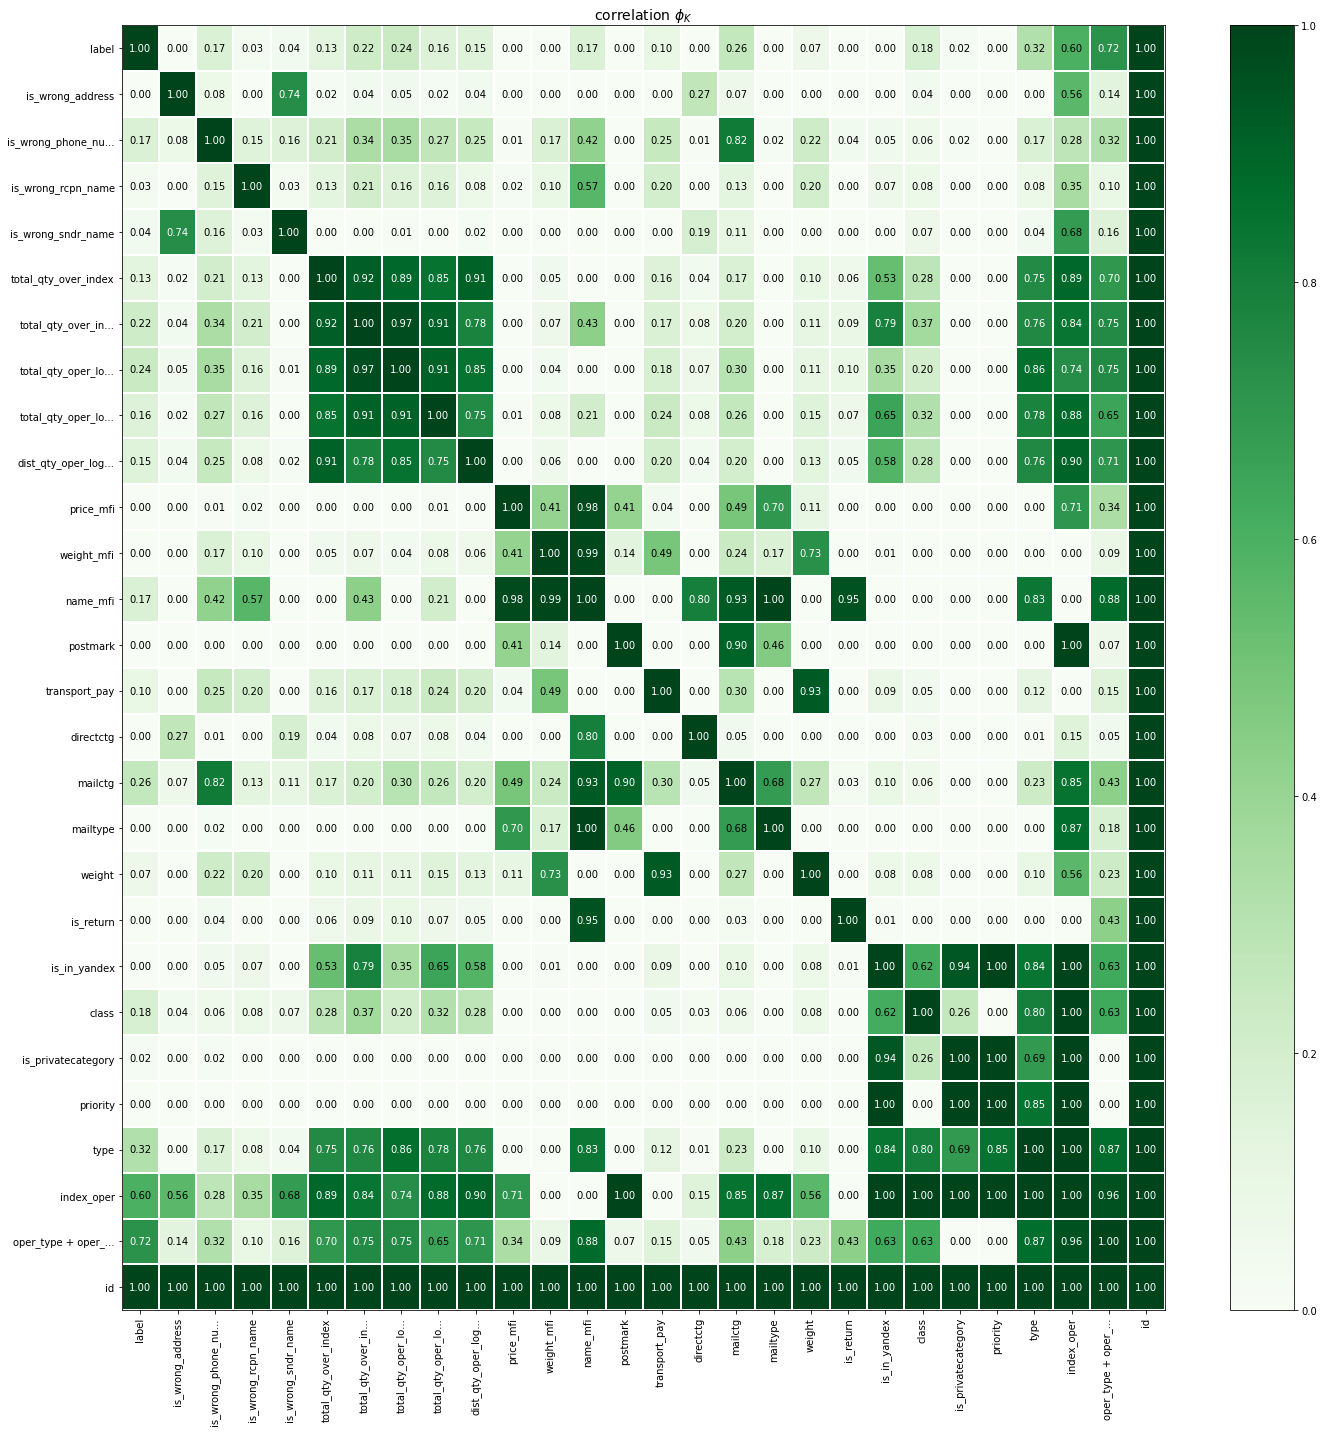

In [36]:
# Построим матрицу корреляции через фи-корреляцию (phik), c помощью 
# которой можно изучать корреляцию признаков 
phik_overview = df_train.sample(5000).phik_matrix()
phik_overview = phik_overview.round(2)
# визуализируем полученную матрицу фи-корреляции
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        #fontsize_factor=1.5, 
                        figsize=(20, 20))
plt.tight_layout()

In [37]:
# Построим матрицу корреляции через фи-корреляцию (phik), c помощью 
# которой можно изучать корреляцию признаков 
#phik_overview = df_test.sample(10000).phik_matrix()
#phik_overview = phik_overview.round(2)
# визуализируем полученную матрицу фи-корреляции
#plot_correlation_matrix(phik_overview.values, 
#                        x_labels=phik_overview.columns, 
#                        y_labels=phik_overview.index, 
#                        vmin=0, vmax=1, color_map="Greens", 
#                        title=r"correlation $\phi_K$", 
                        #fontsize_factor=1.5, 
#                        figsize=(20, 20))
#plt.tight_layout()

In [38]:
# заменим значения в признаке df_train['weight'] на максимальное из двух признаков ввиду пропусков в одном из них:
df_train['weight'] = df_train[['weight', 'weight_mfi']].max(axis =1)
# удалим лишние столбцы [['weight', 'weight_mfi']]
df_train = df_train.drop(['weight_mfi'], axis=1)

# заменим значения в признаке df_test['weight']" на максимальное из двух признаков ввиду пропусков в одном из них:
df_test['weight'] = df_test[['weight', 'weight_mfi']].max(axis =1)
# удалим лишние столбцы [['weight', 'weight_mfi']]
df_test = df_test.drop(['weight_mfi'], axis=1)

In [39]:
# удаление строк не помогло: скор ожидаемо снизился (в тестовом наборе был нули!)
# в тестовом датасете нельзя ничего удалять, иначе не получится df_solution - но я не стал удалять и в train, поэтому не актуально

## Формирование итогового набора признаков после изучения матрицы фи-корреляции

In [40]:
# создадим итоговый список признаков для обучения модели на обучающем датасете: 
# для этого изучим матрицу фи-корреляции и выберем признаки, 
# которые влияют на целевой признак и при этом не дублируют друг друга (нет высокой корреляции)
list_with_importance_features_train_01 = [
                                'oper_type + oper_attr',
                                #'total_qty_oper_login_1',
                                'mailctg',
                                'total_qty_over_index_and_type',
                                #'name_mfi',                            
                                'type',
                                'weight',
                                #'is_wrong_phone_number',
                                'label']

# сформируем итоговый обучающий датасет 
df_train = df_train[list_with_importance_features_train_01]
df_train.info()

# создадим итоговый список признаков для тестирования модели на тестовом датасете
list_with_importance_features_test_01 = []
for i in list_with_importance_features_train_01:
    if i != 'label':
        list_with_importance_features_test_01.append(i)

# сформируем итоговый тестовый датасет 
df_test = df_test[list_with_importance_features_test_01]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 6 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   oper_type + oper_attr          object
 1   mailctg                        object
 2   total_qty_over_index_and_type  int32 
 3   type                           object
 4   weight                         int32 
 5   label                          int8  
dtypes: int32(2), int8(1), object(3)
memory usage: 188.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 5 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   oper_type + oper_attr          object
 1   mailctg                        object
 2   total_qty_over_index_and_type  int32 
 3   type                           object
 4   weight                         int32 
dtypes: int32(2), object(3)
memory usage: 122.1+ MB


### Заполнение пропусков через Imputer

In [41]:
df_train.describe()

,total_qty_over_index_and_type,weight,label
count,6.000000e+06,6.000000e+06,6.000000e+06
mean,5.673982e+07,2.518929e+02,2.849667e-02
std,7.290388e+07,4.556766e+02,1.663869e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.673370e+06,5.900000e+01,0.000000e+00
50%,1.393496e+07,1.150000e+02,0.000000e+00
75%,1.321756e+08,2.770000e+02,0.000000e+00
max,4.897385e+08,1.580000e+05,1.000000e+00


In [42]:
df_test.describe()

,total_qty_over_index_and_type,weight
count,4.000000e+06,4.000000e+06
mean,5.671034e+07,2.519454e+02
std,7.290373e+07,4.031852e+02
min,0.000000e+00,0.000000e+00
25%,1.656011e+06,5.900000e+01
50%,1.393496e+07,1.150000e+02
75%,1.321756e+08,2.780000e+02
max,4.897385e+08,1.580000e+05


In [43]:
# SimpleImputer для обучающего датасета: выберем в список признаки, в которых разумно заполнить пропуски (0)
list_for_simple_imputer = [#'total_qty_oper_login_1',
                           'mailctg',
                           #'name_mfi',
                           'total_qty_over_index_and_type',
                           'type',
                           'weight']

# произведем замену пропусков (0) в обучающем датасете
imputer_train = SimpleImputer(missing_values=0, strategy='most_frequent')
imputer_train.fit(df_train[list_for_simple_imputer])
df_train[list_for_simple_imputer] = imputer_train.transform(df_train[list_for_simple_imputer])

In [44]:
# произведем замену пропусков (0) в тестовом датасете
imputer_test = SimpleImputer(missing_values=0, strategy='most_frequent')
imputer_test.fit(df_test[list_for_simple_imputer])
df_test[list_for_simple_imputer] = imputer_test.transform(df_test[list_for_simple_imputer])

In [45]:
# приведем к нужным типам столбцы df_train после применения SimpleImputer
#df_train['total_qty_oper_login_1'] = df_train['total_qty_oper_login_1'].astype('int32')
df_train['total_qty_over_index_and_type'] = df_train['total_qty_over_index_and_type'].astype('int32')
df_train['weight'] = df_train['weight'].astype('int32')
df_train['label'] = df_train['label'].astype('int8')

# приведем к нужным типам столбцы df_test после применения SimpleImputer
#df_test['total_qty_oper_login_1'] = df_test['total_qty_oper_login_1'].astype('int32')
df_test['total_qty_over_index_and_type'] = df_test['total_qty_over_index_and_type'].astype('int32')
df_test['weight'] = df_test['weight'].astype('int32')

In [46]:
df_train.describe()

,total_qty_over_index_and_type,weight,label
count,6.000000e+06,6.000000e+06,6.000000e+06
mean,5.686472e+07,2.519366e+02,2.849667e-02
std,7.291979e+07,4.556572e+02,1.663869e-01
min,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.673370e+06,5.900000e+01,0.000000e+00
50%,1.393496e+07,1.150000e+02,0.000000e+00
75%,1.321756e+08,2.770000e+02,0.000000e+00
max,4.897385e+08,1.580000e+05,1.000000e+00


In [47]:
df_test.describe()

,total_qty_over_index_and_type,weight
count,4.000000e+06,4.000000e+06
mean,5.683571e+07,2.519903e+02
std,7.291975e+07,4.031627e+02
min,1.000000e+00,1.000000e+00
25%,1.673370e+06,6.000000e+01
50%,1.393496e+07,1.150000e+02
75%,1.321756e+08,2.780000e+02
max,4.897385e+08,1.580000e+05


In [48]:
#df_train.head(20)

In [49]:
#df_test.head(20)

In [50]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 6 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   oper_type + oper_attr          object
 1   mailctg                        object
 2   total_qty_over_index_and_type  int32 
 3   type                           object
 4   weight                         int32 
 5   label                          int8  
dtypes: int32(2), int8(1), object(3)
memory usage: 188.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 5 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   oper_type + oper_attr          object
 1   mailctg                        object
 2   total_qty_over_index_and_type  int32 
 3   type                           object
 4   weight                         int32 
dtypes: int32(2), object(3)
memory usage: 122.1+ MB


In [51]:
# посмотрим, какие признаки модель CatBoostClassifier оценивает как наиболее важные
features_catboost_importance = df_train.drop(['label'], axis = 1).head(3000000)
target_catboost_importance = df_train['label'].head(3000000)

cat_features_categories = list(features_catboost_importance.select_dtypes('object').columns)

catboost = CatBoostClassifier(random_seed=RANDOM_STATE, silent=True, task_type = "GPU", class_weights={0: 15, 1: 502}).fit(features_catboost_importance, target_catboost_importance, cat_features=cat_features_categories)
features_importance = catboost.get_feature_importance()
pd.DataFrame(features_importance, index=features_catboost_importance.dtypes.index, columns=['Важность признаков для CatBoostClassifier'])\
    .sort_values(by='Важность признаков для CatBoostClassifier', ascending = False).style.bar()

,Важность признаков для CatBoostClassifier
oper_type + oper_attr,46.924472
total_qty_over_index_and_type,24.360653
type,13.877763
weight,8.795005
mailctg,6.042107


interval columns not set, guessing: ['total_qty_over_index_and_type', 'weight', 'label']


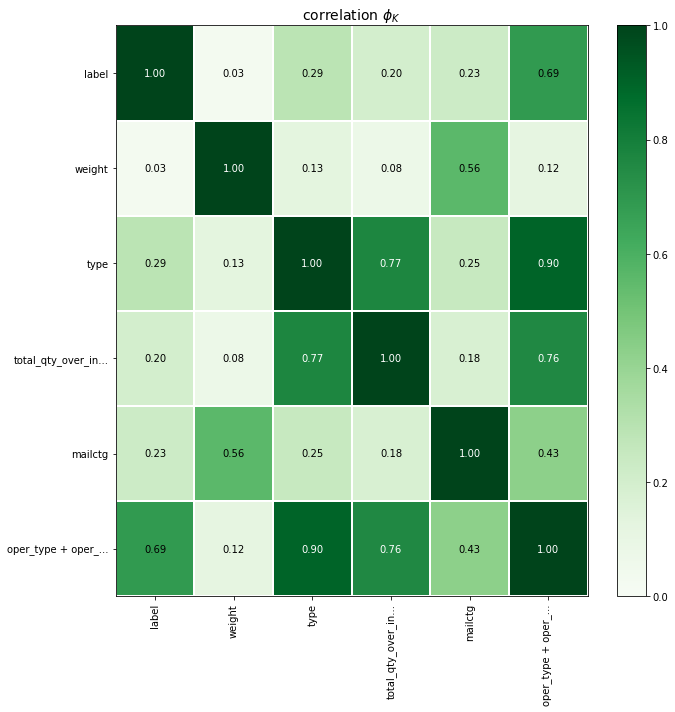

In [52]:
# Построим матрицу корреляции через фи-корреляцию (phik), c помощью 
# которой можно изучать корреляцию непрерывных категориальных признаков 
phik_overview = df_train.sample(30000).phik_matrix()
phik_overview = phik_overview.round(2)
# визуализируем полученную матрицу фи-корреляции
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        #fontsize_factor=1.5, 
                        figsize=(10, 10))
plt.tight_layout()

In [53]:
for i in list_with_importance_features_train_01:
    print(i)
    print(df_train[i].value_counts())
    print('--------------------------------------------')
    print('--------------------------------------------')
    print('--------------------------------------------')

oper_type + oper_attr
1020_-1    693154
1022_-1    656597
1019_-1    413710
8_0        402877
1_-1       359402
            ...  
2_2             1
12_6            1
2_11            1
2_10            1
1009_-1         1
Name: oper_type + oper_attr, Length: 109, dtype: int64
--------------------------------------------
--------------------------------------------
--------------------------------------------
mailctg
1.0_mailctg     4688317
0.0_mailctg     1257102
-1.0_mailctg      54015
3.0_mailctg         546
5.0_mailctg          20
Name: mailctg, dtype: int64
--------------------------------------------
--------------------------------------------
--------------------------------------------
total_qty_over_index_and_type
132175590    801556
180702765    334082
67549084     329741
159889293    272750
76146936     159450
              ...  
3547              1
6456              1
10538             1
2940              1
368597            1
Name: total_qty_over_index_and_type, Length: 2009

In [54]:
for i in list_with_importance_features_test_01:
    print(i)
    print(df_test[i].value_counts())
    print('--------------------------------------------')
    print('--------------------------------------------')
    print('--------------------------------------------')

oper_type + oper_attr
1020_-1    461403
1022_-1    437702
1019_-1    276312
8_0        268559
1_-1       240459
            ...  
12_21           1
14_19           1
1009_-1         1
6_5             1
3_10            1
Name: oper_type + oper_attr, Length: 102, dtype: int64
--------------------------------------------
--------------------------------------------
--------------------------------------------
mailctg
1.0_mailctg     3127158
0.0_mailctg      836708
-1.0_mailctg      35737
3.0_mailctg         383
5.0_mailctg          14
Name: mailctg, dtype: int64
--------------------------------------------
--------------------------------------------
--------------------------------------------
total_qty_over_index_and_type
132175590    533997
180702765    222425
67549084     219208
159889293    182242
76146936     106650
              ...  
4536              1
5265              1
2877              1
4289              1
10995             1
Name: total_qty_over_index_and_type, Length: 1997

In [55]:
# взвешивание классов для модели
k_for_class_0 = np.sum(df_train['label']==1)
k_for_class_1 = np.sum(df_train['label']==0)

print(k_for_class_0)
print(k_for_class_1)

170980
5829020


In [56]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 6 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   oper_type + oper_attr          object
 1   mailctg                        object
 2   total_qty_over_index_and_type  int32 
 3   type                           object
 4   weight                         int32 
 5   label                          int8  
dtypes: int32(2), int8(1), object(3)
memory usage: 188.8+ MB


In [57]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 5 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   oper_type + oper_attr          object
 1   mailctg                        object
 2   total_qty_over_index_and_type  int32 
 3   type                           object
 4   weight                         int32 
dtypes: int32(2), object(3)
memory usage: 122.1+ MB


## Формула метрики

In [58]:
# для CatBoost: при использовании в grid_search_catboost результат получается хуже, поэтому там оставим scoring='roc_auc_ovo'
def metric_from_assignment(target, predict):
    target = target_train_catboost
    predict = grid_search_catboost.predict(features_train_catboost)
    metric_from_assignment = 0.9 * roc_auc_score(target, predict, multi_class='ovo') + 0.1 * recall_score(target, predict, average = "macro" ) 
    return metric_from_assignment

In [59]:
# формула для LGBM
#def metric_from_assignment_lgbm(X_train_lgbm, y_train_lgbm):
#    predict_lgbm = grid_search_lgbm.predict(X_train_lgbm)
#    metric_from_assignment_lgbm = 0.9 * roc_auc_score(y_train_lgbm, predict_lgbm, multi_class='ovo') + 0.1 * recall_score(y_train_lgbm, predict_lgbm, average = "macro" ) 
#    return metric_from_assignment_lgbm

## Обучение моделей

### LightGBM

In [60]:
# получим список категориальных признаков 
#features_categories = list(features_train_catboost.select_dtypes('object').columns)
#display(features_categories)

In [61]:
# моделирование завершается ошибкой памяти!
#X_train_lgbm = features_train_catboost.head(1000)
#y_train_lgbm = target_train_catboost.head(1000)

#pipe_lgbm = Pipeline(steps=[('scaler', StandardScaler()),
#                            ('lgbm', LGBMClassifier(random_state=RANDOM_STATE,
#                                                    objective='binary',
#                                                    class_weight='balanced',
#                                                    silent=True))])

#lgbm_params = {
# 'lgbm__max_depth': [2],
# 'lgbm__n_estimators': [50],
# 'lgbm__learning_rate': [0.05],
# 'categorical_feature': features_categories
#}

#grid_search_lgbm = GridSearchCV(pipe_lgbm,
#                                lgbm_params, 
#                                verbose=2,
#                                cv=2,
#                                n_jobs=-1,
#                                scoring='roc_auc')

#grid_search_lgbm.fit(X_train_lgbm, y_train_lgbm)

#print(" --------------------------------------------------------------------------" )
#print(" --------------------------------------------------------------------------" )
#print(" Results from Grid Search " )
#print("\n The best estimator across ALL searched params:\n", grid_search_lgbm.best_estimator_)
#print("\n The best score across ALL searched params:\n", grid_search_lgbm.best_score_)
#print("\n The best parameters across ALL searched params:\n", grid_search_lgbm.best_params_)'''

In [62]:
#pred_lgbm_solution = grid_search_lgbm.predict(df_test)

### CatBoostClassifier

In [123]:
# сократим датафрейм df_train для быстрого обучения и тестирования модели
df_cat = df_train.copy()

In [124]:
# выделим признаки для обучения моделей
features_catboost = df_cat.drop(['label'], axis = 1)
target_catboost = df_cat['label']

In [125]:
features_catboost.info()
target_catboost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 5 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   oper_type + oper_attr          object
 1   mailctg                        object
 2   total_qty_over_index_and_type  int32 
 3   type                           object
 4   weight                         int32 
dtypes: int32(2), object(3)
memory usage: 183.1+ MB
<class 'pandas.core.series.Series'>
RangeIndex: 6000000 entries, 0 to 5999999
Series name: label
Non-Null Count    Dtype
--------------    -----
6000000 non-null  int8 
dtypes: int8(1)
memory usage: 5.7 MB


In [126]:
#from imblearn.over_sampling import BorderlineSMOTE
#borderline_smote = BorderlineSMOTE(random_state=RANDOM_STATE)
#features_catboost, target_catboost = borderline_smote.fit_resample(features_catboost, target_catboost)

In [127]:
# DOWNSAMPLING
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RANDOM_STATE)
    return features_downsampled, target_downsampled

In [128]:
# DOWNSAMPLING
features_catboost, target_catboost = downsample(features_catboost, target_catboost, fraction = FRACTION_FOR_DOWNSAMPLING)

In [129]:
features_catboost.info()
target_catboost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000000 entries, 3613385 to 1778156
Data columns (total 5 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   oper_type + oper_attr          object
 1   mailctg                        object
 2   total_qty_over_index_and_type  int32 
 3   type                           object
 4   weight                         int32 
dtypes: int32(2), object(3)
memory usage: 228.9+ MB
<class 'pandas.core.series.Series'>
Int64Index: 6000000 entries, 3613385 to 1778156
Series name: label
Non-Null Count    Dtype
--------------    -----
6000000 non-null  int8 
dtypes: int8(1)
memory usage: 51.5 MB


In [130]:
# разделим датафрейм на обучающую и тестовую выборки, при этом 
# используем стратификацию (параметр stratify), чтобы сбалансировать 
# выборки по классам (для целевого признака target)

features_train_catboost, features_test_catboost, target_train_catboost, target_test_catboost = train_test_split(
    features_catboost, target_catboost, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=target_catboost)

if features_train_catboost.shape[0]==target_train_catboost.shape[0] and features_test_catboost.shape[0]==target_test_catboost.shape[0]:
    print('All is good: sample sizes are correct')
else:
    print('Error!!! Sample sizes are NOT correct')

features_train_catboost.shape, target_train_catboost.shape, features_test_catboost.shape, target_test_catboost.shape

All is good: sample sizes are correct


((4200000, 5), (4200000,), (1800000, 5), (1800000,))

In [131]:
# получим список категориальных признаков 
cat_features_categories = list(features_train_catboost.select_dtypes('object').columns)
display(cat_features_categories)

['oper_type + oper_attr', 'mailctg', 'type']

In [132]:
features_train_catboost.info()
features_train_catboost.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4200000 entries, 172779 to 4827591
Data columns (total 5 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   oper_type + oper_attr          object
 1   mailctg                        object
 2   total_qty_over_index_and_type  int32 
 3   type                           object
 4   weight                         int32 
dtypes: int32(2), object(3)
memory usage: 160.2+ MB


,oper_type + oper_attr,mailctg,total_qty_over_index_and_type,type,weight
172779,1025_-1,1.0_mailctg,156605292,ММПО,17
3679432,1014_-1,0.0_mailctg,180702765,ММПО,24
3741968,1018_-1,0.0_mailctg,48784066,Цех,101
5695778,1019_-1,0.0_mailctg,444261,П,70
2462978,1020_-1,0.0_mailctg,1693974,Цех,60


In [133]:
# для CatBoost показывает низкие результаты
'''# создадим объект структуры  StandardScaler и настроим его на обучающих данных
numeric = features_train_catboost.select_dtypes(include=['int', 'float'], exclude=None).columns

scaler = StandardScaler()
scaler.fit(features_train_catboost[numeric]) # список всех численных признаков (если не передать, то будет ошибка типов)

# Преобразуем обучающую и тестовую выборки функцией transform(). 
features_train_catboost[numeric] = scaler.transform(features_train_catboost[numeric])
features_test_catboost[numeric] = scaler.transform(features_test_catboost[numeric])

display(features_train_catboost.head())
display(features_test_catboost.head())'''

"# создадим объект структуры  StandardScaler и настроим его на обучающих данных\nnumeric = features_train_catboost.select_dtypes(include=['int', 'float'], exclude=None).columns\n\nscaler = StandardScaler()\nscaler.fit(features_train_catboost[numeric]) # список всех численных признаков (если не передать, то будет ошибка типов)\n\n# Преобразуем обучающую и тестовую выборки функцией transform(). \nfeatures_train_catboost[numeric] = scaler.transform(features_train_catboost[numeric])\nfeatures_test_catboost[numeric] = scaler.transform(features_test_catboost[numeric])\n\ndisplay(features_train_catboost.head())\ndisplay(features_test_catboost.head())"

In [134]:
import numpy as np 
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight

In [135]:
# сбалансируем классы для модели
classes = np.unique(target_train_catboost)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train_catboost)
class_weights_catboost = dict(zip(classes, weights))
print(class_weights_catboost)

{0: 0.5146662732328934, 1: 17.545911802550005}


In [136]:
#class_weights_catboost_balance = {0: 1, 1: 20}
class_weights_catboost_balance = class_weights_catboost

In [137]:
%%time
# создадим и обучим модель, подобрав гиперпараметры через GridSearchCV
catboost = CatBoostClassifier(loss_function='Logloss', 
                              task_type = "GPU", 
                              random_seed=RANDOM_STATE,
                              class_weights=class_weights_catboost_balance,
                              silent=True)

catboost_params = {
 'depth': [8],
 'iterations': [1000]
 #'class_weights': [{0: 1, 1: [40, 100]}]
 #'learning_rate': [0.1]
 #'l2_leaf_reg': [3]
}

grid_search_catboost = GridSearchCV(catboost,
                                   catboost_params,                                   
                                   verbose=2,
                                   cv=5,
                                   #n_jobs=-1,
                                   #scoring=metric_from_assignment
                                   scoring='roc_auc_ovo')

grid_search_catboost.fit(features_train_catboost, target_train_catboost, cat_features=cat_features_categories)

print(" --------------------------------------------------------------------------" )
print(" --------------------------------------------------------------------------" )
print(" Results from Grid Search " )
print("\n The best score across ALL searched params:\n", grid_search_catboost.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_search_catboost.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...........................depth=8, iterations=1000; total time= 4.5min
[CV] END ...........................depth=8, iterations=1000; total time= 4.5min
[CV] END ...........................depth=8, iterations=1000; total time= 4.6min
[CV] END ...........................depth=8, iterations=1000; total time= 4.5min
[CV] END ...........................depth=8, iterations=1000; total time= 4.6min
 --------------------------------------------------------------------------
 --------------------------------------------------------------------------
 Results from Grid Search 

 The best score across ALL searched params:
 0.9872285378379726

 The best parameters across ALL searched params:
 {'depth': 8, 'iterations': 1000}
CPU times: total: 48min 1s
Wall time: 27min 55s


## Оценка точности

In [138]:
# сделаем предсказание
pred_cat = grid_search_catboost.predict(features_test_catboost)

In [139]:
# сохраним модель на диск для последующей загрузки без долгого обучения
filename_saved_model_cat = 'cat_finalized_model.sav'
pickle.dump(grid_search_catboost, open(filename_saved_model_cat, 'wb'))

In [140]:
# загрузим модель с диска
loaded_model_cat = pickle.load(open(filename_saved_model_cat, 'rb'))
#result = loaded_model_cat.score(features_test_catboost, target_test_catboost)
#print(result)

In [141]:
# посчитаем итоговые метрики
pred_loaded_cat = loaded_model_cat.predict(features_test_catboost)

score_loaded_cat_recall = recall_score(target_test_catboost, pred_loaded_cat, average = "macro" )
print("Recall =", score_loaded_cat_recall)

Recall = 0.9762029497096125


ROC-AUC= 0.9872099941633513


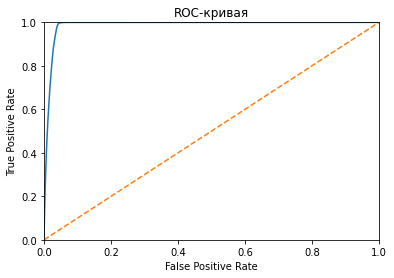

In [142]:
# получаем предказания predict_proba
probs = loaded_model_cat.predict_proba(features_test_catboost)
# сохраняем вероятности только для положительного исхода
probs = probs[:, 1]
# рассчитываем ROC-AUC
auc = roc_auc_score(target_test_catboost, probs, multi_class='ovo')
print('ROC-AUC=', auc)

probabilities_test = loaded_model_cat.predict_proba(features_test_catboost)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test_catboost, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

# границы осей от 0 до 1 
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
# подписи осей "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# заголовок
plt.title('ROC-кривая')
#plt.figure(figsize=(6, 6))
plt.show()

In [143]:
pred_loaded_cat_solution = loaded_model_cat.predict(df_test)
print(pred_loaded_cat_solution)

[0 0 0 ... 0 0 0]


Text(0.5, 1, 'CatBoost: матрица ошибок')

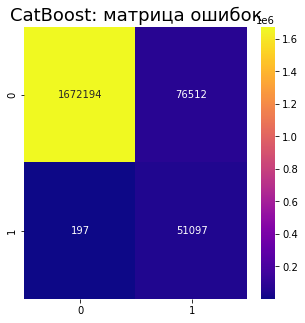

In [144]:
# построим матрицу ошибок
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix(target_test_catboost, pred_loaded_cat),annot=True,fmt='3.0f',cmap="plasma")
plt.title('CatBoost: матрица ошибок', y=1, size=18)

# 6 Выгрузка итогового решения в csv

In [145]:
# создадим датасет c предсказаниями
y_pred = pred_loaded_cat_solution
df_y_pred = pd.DataFrame(y_pred)
df_y_pred.rename(columns = {0 : 'label'}, inplace = True)

# посмотрим статистики
#df_y_pred.describe()

In [146]:
# объединим в итоговый датасет с решением 
df_sample_solution_final_catboost = df_y_pred
df_sample_solution_final_catboost['id'] = df_sample_solution['id']
df_sample_solution_final_catboost = df_sample_solution_final_catboost[['id', 'label']]

df_sample_solution_final_catboost['id'] = df_sample_solution_final_catboost['id'].astype('int')
df_sample_solution_final_catboost['label'] = df_sample_solution_final_catboost['label'].astype('int')

#display(df_sample_solution_final_catboost)
#df_sample_solution_final_catboost.describe()

In [147]:
# сохраним результат предсказания в 'csv' файл
df_sample_solution_final_catboost.to_csv('df_sample_solution_final_pochta.csv', sep=",", index=False, line_terminator='\n')

In [148]:
# вычислим метрику metric_09AUC_01Recall (итоговая метрика)
metric_09AUC_01Recall = metric_from_assignment(target_train_catboost, grid_search_catboost.predict(features_train_catboost))
print(metric_09AUC_01Recall)

0.9761200546328956


In [ ]:
print("TEST_SIZE =", TEST_SIZE)  #размер тестовой выборки
print("FRACTION_FOR_DOWNSAMPLING =", FRACTION_FOR_DOWNSAMPLING) #размер выборки для DOWNSAMPLING (доля "0" по 'label' от датасета для обучающей выборки)
print("----------------------------------------")
# итоговые метрики:
print("           GridSearch =", grid_search_catboost.best_score_)
print("           ! Recall   =", score_loaded_cat_recall) 
print("              ROC-AUC =", auc)
print("metric_09AUC_01Recall =", metric_09AUC_01Recall)
print("----------------------------------------")
pred_loaded_cat_solution_1 = np.sum(pred_loaded_cat_solution==1)
pred_loaded_cat_solution_0 = np.sum(pred_loaded_cat_solution==0)
pred_loaded_cat_solution_percent1 = pred_loaded_cat_solution_1 / (pred_loaded_cat_solution_1 + pred_loaded_cat_solution_0)
print(f"Процент единиц в предсказании = {pred_loaded_cat_solution_percent1:0.2%}")
print(f"Итого единиц в предсказании   = {pred_loaded_cat_solution_1}")
print(f"Итого нулей  в предсказании   = {pred_loaded_cat_solution_0}")
print(f"Итого выборка  предсказания   = {pred_loaded_cat_solution_0 + pred_loaded_cat_solution_1}")
print("----------------------------------------")
print("\n Варианты для подбора гиперпараметров модели:\n", catboost_params)
print("\n Лучшие гиперпараметры модели :\n", grid_search_catboost.best_params_)